# ENERGETIC PATHWAYS
This code follows Umlauf et al. 2015 in exploring the energy pathways between MKE, MPE, EKE, and EPE.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import h5py
from pylab import *
import scipy.integrate as integrate
#from cmocean import cm as cmo
import matplotlib.gridspec as gridspec
import matplotlib.ticker 
import scipy.stats as stats
import scipy.optimize as optimize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.signal import savgol_filter

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

In [3]:
#%% Pick the filename and path
filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/snapshots_0p10.h5' #0.1 slope
filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p05/snapshots/snapshots_1e-5_0p05.h5' #0.1 slope
#filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_5e-7_0p42/snapshots/snapshots_5e-7_0p42.h5' #0.1 slope
#filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p0225/snapshots/snapshots_1e-5_0p0225.h5' #0.1 slope
filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02/snapshots/snapshots_1e-5_0p02_LONG.h5' #Ruan case F
# filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02/snapshots/snapshots_1e-5_0p02.h5' #Ruan case F

#filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-7_0p005/snapshots/snapshots_1e-7_0p005.h5' #Ruan case A
# filename =  '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-6_0p01/snapshots/snapshots_1e-6_0p01.h5'
# filename =  '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-6_0p1/snapshots/snapshots_1e-6_0p1.h5'

f = h5py.File(filename, 'r')

# Get the data
data = list(f['tasks'])

# Basic parameters
N = f['tasks']['N'][0,0,0] #Interior stratification (background)
tht = f['tasks']['tht'] # Slope angle


# Load variables in physical space
u = f['tasks']['u'] # Cross-slope direction
v = f['tasks']['v'] # Along-slope direction
w = f['tasks']['w'] # Slope-normal direction
b = f['tasks']['b'] # Perturbation buoyancy

qa = f['tasks']['PVa']
q = f['tasks']['PV']

# Energy terms XXX - Need to go clean these up in Dedalus
gsp = f['tasks']['GSP']
gspr = f['tasks']['GSProtated']
vspu = f['tasks']['VSPu']
vspv = f['tasks']['VSPv']
vsp = vspu[:,:,:]+vspv[:,:,:]
lspu = f['tasks']['LSPu']
lspv = f['tasks']['LSPv']
lsp = lspu[:,:,:] + lspv[:,:,:]
diss = f['tasks']['Diss']
dissb = f['tasks']['DISSBPRIME']

vbf = f['tasks']['VBF']
vbfr = f['tasks']['VBFr']
hbfr = f['tasks']['HBFrotated']
hbfr = hbfr*np.sin(tht[0,0,0])
vbfrot = f['tasks']['VBFrotated']
sp = f['tasks']['SP']
EKE = f['tasks']['EKE']

# SPECTRAL QUANTITIES
ws = f['tasks']['wcs']
bs = f['tasks']['bs']
vs = f['tasks']['vcs']


# Domain parameters
x = u.dims[1][0][:]
z = u.dims[2][0][:]
time = u.dims[0][0][:]
kx = f['scales/kx'][:]/(2*np.pi) # Inverse wavelengths in cross-front direction

# Calculations
zm = z-z[-1]

um = np.mean(u, axis=1)
vm = np.mean(v, axis=1)
up = u - um[:,np.newaxis,:]
vp = v - vm[:,np.newaxis,:]

uz = np.gradient(um, axis=-1)/np.gradient(z)
vz = np.gradient(vm, axis=-1)/np.gradient(z) 
wz = np.gradient(w, axis=-1)/np.gradient(z)
wx = np.gradient(w, axis=1)/np.gradient(x[np.newaxis,:,np.newaxis], axis=1)
EKEt = np.gradient(EKE[:,0,:], axis=0)/np.gradient(time[:,np.newaxis], axis=0)

MKE = 0.5*(um**2 + (vm)**2)
MKEt = np.gradient(MKE, axis=0)/np.gradient(time[:,np.newaxis], axis=0)

MAPE = 0.5*np.mean(b[:,:,:]**2, axis=1)/N**2
MAPEt = np.gradient(MAPE, axis=0)/np.gradient(time[:,np.newaxis], axis=0)



In [3]:
time = u.dims[0][0][:]

In [4]:
# Mean Buoyancy budget terms
bm = np.mean(b, axis=1)
bmz = np.gradient(bm, axis=-1)/np.gradient(z)
MPE = 0.5*bm**2/N**2
MKEMPE = um[:,:]*bm*np.sin(tht[0,0,0])
BPROD = vbfrot[:,0,:]*(bmz/N**2)
MMIX = -1e-4*bmz**2/N**2 - 1e-4*bmz # need to confirm whether this is correct (ie D(b, bz + N**2))

In [5]:
# Eddy buoyancy budget terms
bp = b - bm[:,np.newaxis,:]
bpx = np.gradient(bp, axis=1)/np.gradient(x[np.newaxis,:,np.newaxis], axis=1)
bpz = np.gradient(bp, axis=-1)/np.gradient(z)
bpxx = np.gradient(bpx, axis=1)/np.gradient(x[np.newaxis,:,np.newaxis], axis=1)
bpzz = np.gradient(bpz, axis=-1)/np.gradient(z)
EPE = np.mean(bp**2, axis=1)/(2*N**2)
MIX = -1e-4/N**2*np.mean(bpx**2 + bpz**2, axis=1)
# MIX = 1e-4/N**2*np.mean(bp*(bpxx + bpzz), axis=1)

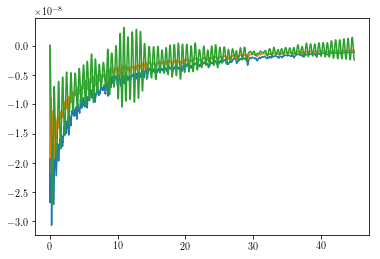

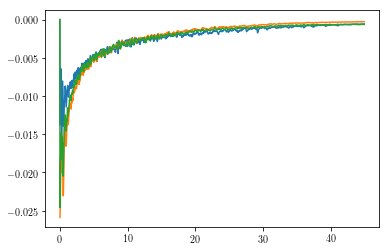

In [6]:
uss = 1e-4*np.sqrt(uz[:,0]**2 + vz[:,0]**2) # This is u*^2...need to confirm this definition
uss = 1e-4*np.sqrt(uz[:,0]**2 + vz[:,0]**2)
us = np.sqrt(uss)
usm = np.mean(us)
delv = 1e-4/usm

tauy = -1035*1e-4*vz[:,0]#Note that 1e-4 is the viscosity for the DNS
taux = -1035*1e-4*uz[:,0] #Note that 1e-4 is the viscosity for the DNS

zind = 16
cd = 2.5e-3
tauya = -1035*cd*np.mean(np.sqrt(u[:,:,zind]**2 + (v[:,:,zind]+0.1)**2)*(v[:,:,zind]+0.1), axis=1)
#tauy= tauya
# This plot is to confirm that the viscous layer is being resolved
#plt.figure()
#plt.plot((z[1:]-z[:-1])/delv, 0.5*(z[1:] + z[:-1]), marker='x')

# calculate bottom velocity at 50*delv
nt = time.size
ub = np.zeros((nt,))
vb = np.zeros((nt,))
for i in range(1,nt):
    tempind = np.where(z>50*1e-4/us[i])[0][0]
    ub[i] = um[i,tempind]
    vb[i] = vm[i,tempind]+0.1
# Can calculate the Ekman transport using bottom stress:
Bek = tauy/(1030*1e-4)*N**2*np.sin(tht[:,0,0])
Beka = tauy/(1030*1e-4*(1+N**2*np.sin(tht[0,0,0])**2/1e-8))*N**2*np.sin(tht[:,0,0])

# Alternately calculate the actual cross-slope buoyancy transport
Ubar = integrate.trapz(um,x=zm, axis=-1 )
BekD = Ubar*N**2*np.sin(tht[:,0,0])
#Bek = Beka
# Compare three estimates of stress
plt.plot(time/86400, Bek)
plt.plot(time/86400, Beka)
plt.plot(time/86400, BekD)

plt.figure()
plt.plot(time/86400, tauy)
plt.plot(time/86400, tauya)
plt.plot(time/86400, -1030*cd*np.sqrt(ub**2 + vb**2)*vb)

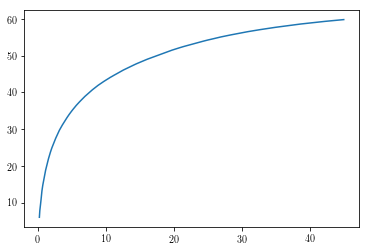

In [7]:
nt = BekD.shape[0]

toff = 12*2 # Starting timestep
Ho = 14 # Pick a starting depth (not necessarily starting at t=0, H=0)

toff = 12
Ho = 5
Ent = 1.0 # Entrainment factor...
H2 = np.zeros((nt, )) 
for i in range(toff, nt):
    H2[i] = H2[i-1]+(2*Ent*-Bek[i]/(N**2))*(time[i]-time[i-1])
    
H = np.sqrt(Ho**2 + H2)
H[0:toff] = np.nan
plt.plot(time/86400, H)

NameError: name 'dissp' is not defined

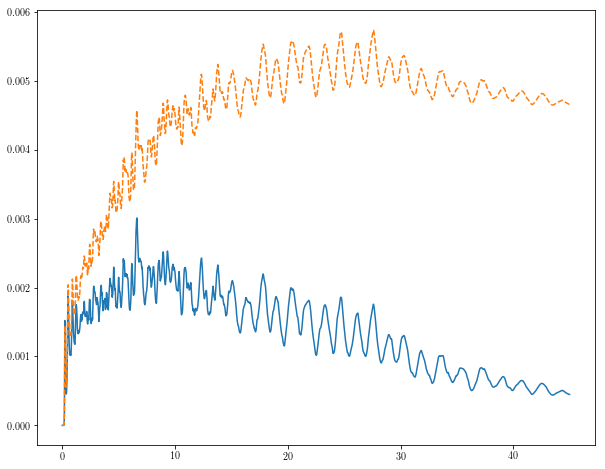

In [23]:
# Sanity check to confirm EKE budget is closed CUMULATIVE
#%% Plot the depth integrated energy budget (constant depth range)
zl = range(0, zm.size)
zl = np.where((zm>=zm[0]+0) & (zm<zm[0]+300))[0]

zd = zm[zl[-1]] - zm[zl[0]]
# ETEST = np.mean(0.5*(up[:,:,:]**2 + vp[:,:,:]**2 +w[:,:,:]**2), axis=1)
WDISS = -1e-4*np.mean(wz**2 + wx**2, axis=1)
plt.figure(figsize=(10,8))
plt.plot(time/86400, integrate.trapz(EKE[:,0,zl], x=zm[zl], axis=-1), label='EKE$_t$') # Rate of change of EKE
# plt.plot(time/86400, integrate.trapz(ETEST[:,zl], x=zm[zl], axis=-1), label='EKE$_t$') # Rate of change of EKE
# plt.plot(time/86400, integrate.cumtrapz(integrate.trapz(WDISS[:,zl], x=zm[zl], axis=-1), x=time, initial=0), label='WDISS') # Rate of change of EKE

plt.plot(time/86400,integrate.cumtrapz(integrate.trapz(diss[:,0,zl]+vbfr[:,0,zl]-sp[:,0,zl]+WDISS[:,zl], x=zm[zl], axis=-1), x=time, initial=0), linestyle='dashed', label='SUM')
plt.plot(time/86400,DRAGI+DAMPI+integrate.cumtrapz(integrate.trapz(diss[:,0,zl]+vbfr[:,0,zl]-sp[:,0,zl]+WDISS[:,zl], x=zm[zl], axis=-1), x=time, initial=0), linestyle='dashed', label='SUM')

plt.legend()

## MKE

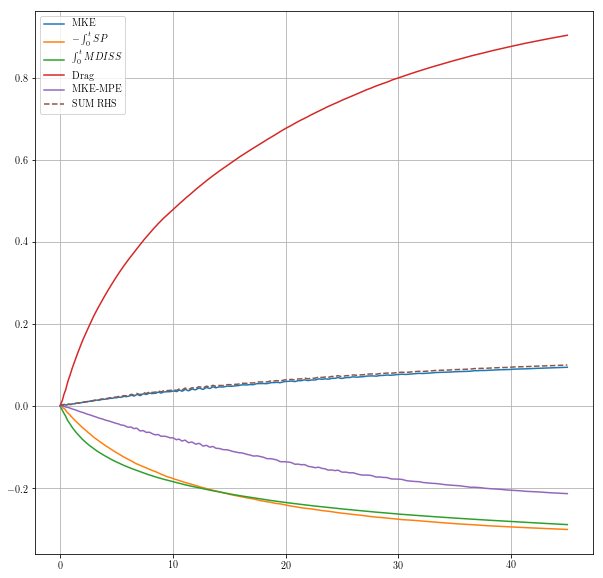

In [9]:
#Compare change in MKE to MAPE
# bdrag = 1030*cd*ubt**3/1030
bdrag = (vm[:,0])*tauy/(1030)
# bdrags = 1e-3*0.1**3 + 0*tauy
damp = -0.005*((-20 - (z-200))/20)**2
damp[(z[:]-200)<-20] = 0
damp = damp*um*um + damp*vm*vm
mdiss = 1e-4*uz**2 + 1e-4*vz**2
startind=48*0
zl = np.where((zm>-200+0) & (zm<zm[0]+200))[0]

plt.figure(figsize=(10,10))
MKI = integrate.trapz(MKE[startind:,zl], x=z[zl], axis=-1)  - integrate.trapz(MKE[startind:,zl], x=z[zl], axis=-1)[0]
DRAGI = integrate.cumtrapz(bdrag[startind:], x=time[startind:], initial=0)
# DRAGSI = integrate.cumtrapz(bdrags[startind:], x=time[startind:], initial=0)

DISSI = integrate.cumtrapz(-integrate.trapz(mdiss[startind:,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)
SPI = integrate.cumtrapz(integrate.trapz(sp[startind:,0,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)
MKEMPEI = integrate.cumtrapz(integrate.trapz(MKEMPE[startind:,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)
SUM = DRAGI + DISSI + SPI + MKEMPEI
plt.plot(time[startind:]/86400, MKI, label='MKE')
plt.plot(time[startind:]/86400, SPI, label='$-\int_0^t SP$')
# plt.plot(time[startind:]/86400, integrate.cumtrapz(integrate.trapz(damp[startind:,zl], x=z[zl], axis=-1), x=time[startind:], initial=0), label='$Damp$')
plt.plot(time[startind:]/86400, DISSI, label='$\int_0^t MDISS$')

# # plt.plot(time/86400, np.sqrt(S)*N*H/(2*(1+S)*ubt)*dissi, label='Scaling')
# plt.plot(time[startind:]/86400, integrate.cumtrapz(H[startind:]*Beka[startind:]/2, x=time[startind:], initial=0), label='Scaling')
plt.plot(time[startind:]/86400, DRAGI, label='Drag')
# plt.plot(time[startind:]/86400, DRAGSI, label='Drag Scaling')

# plt.plot(time[startind:]/86400, integrate.cumtrapz(bdrag[startind:], x=time[startind:], initial=0), label='Drag')
plt.plot(time[startind:]/86400, MKEMPEI, label='MKE-MPE')
plt.plot(time[startind:]/86400, SUM, linestyle='dashed', label='SUM RHS')
plt.legend()
plt.grid()

## EKE


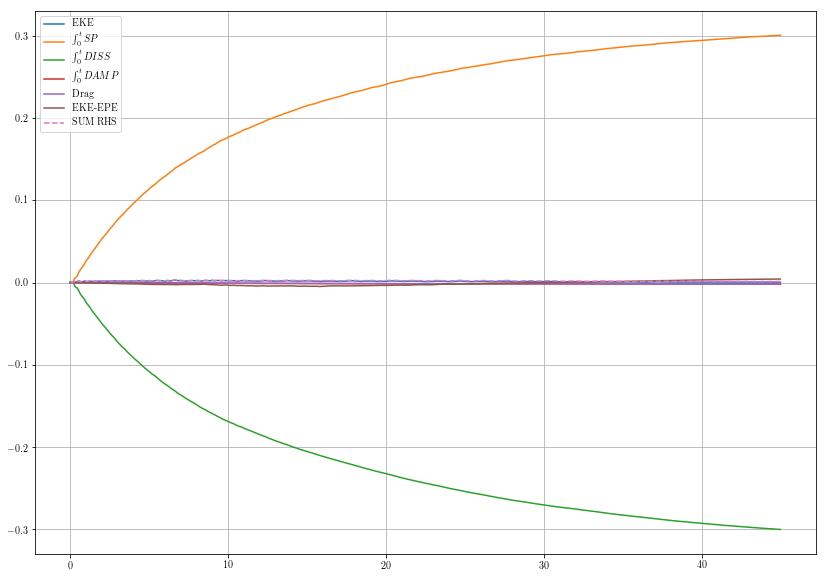

In [10]:
#Compare change in EKE to EPE

bdrag = (vm[:,0])*tauy/(1030)
damp = -0.005*((-20 - (z-z[-1]))/20)**2
damp[(z[:]-z[-1])<-20] = 0

damp = np.mean(damp*up*up + damp*vp*vp + damp*w[:,:,:]**2, axis=1)

EKETEST = EKE 
startind=48*0
zl = np.where((z>0) & (z<=z[-1]))[0]
bdrag = -1e-4*(EKE[:,0,1] - EKE[:,0,0])/(z[1]-z[0])
plt.figure(figsize=(14,10))
EKI = integrate.trapz(EKETEST[startind:,0,zl], x=z[zl], axis=-1)  - integrate.trapz(EKETEST[startind:,0,zl], x=z[zl], axis=-1)[0]
DRAGI = integrate.cumtrapz(bdrag[startind:], x=time[startind:], initial=0)
# DRAGSI = integrate.cumtrapz(bdrags[startind:], x=time[startind:], initial=0)
DAMPI = integrate.cumtrapz(integrate.trapz(damp[startind:,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)

# wzdiss = 1e-4*np.mean((np.gradient(w, axis=-1)/np.gradient(z[np.newaxis,np.newaxis,:], axis=-1))**2, axis=1)
DISSI = integrate.cumtrapz(integrate.trapz(diss[startind:,0,zl]+WDISS[startind:,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)
SPI = -integrate.cumtrapz(integrate.trapz(sp[startind:,0,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)
EKEEPEI = integrate.cumtrapz(integrate.trapz(vbfr[startind:,0,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)
SUM = DRAGI + DISSI + SPI + EKEEPEI+DAMPI

plt.plot(time[startind:]/86400, EKI, label='EKE')
plt.plot(time[startind:]/86400, SPI, label='$\int_0^t SP$')
# plt.plot(time[startind:]/86400, integrate.cumtrapz(integrate.trapz(damp[startind:,zl], x=z[zl], axis=-1), x=time[startind:], initial=0), label='$Damp$')
plt.plot(time[startind:]/86400, DISSI, label='$\int_0^t DISS$')
plt.plot(time[startind:]/86400, DAMPI, label='$\int_0^t DAMP$')

# # plt.plot(time/86400, np.sqrt(S)*N*H/(2*(1+S)*ubt)*dissi, label='Scaling')
# plt.plot(time[startind:]/86400, integrate.cumtrapz(H[startind:]*Beka[startind:]/2, x=time[startind:], initial=0), label='Scaling')
plt.plot(time[startind:]/86400, DRAGI, label='Drag')
# plt.plot(time[startind:]/86400, DRAGSI, label='Drag Scaling')

# plt.plot(time[startind:]/86400, integrate.cumtrapz(bdrag[startind:], x=time[startind:], initial=0), label='Drag')
plt.plot(time[startind:]/86400, EKEEPEI, label='EKE-EPE')
plt.plot(time[startind:]/86400, SUM, linestyle='dashed', label='SUM RHS')
plt.legend()
plt.grid()
# plt.ylim((-2e-2, 2e-2))

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


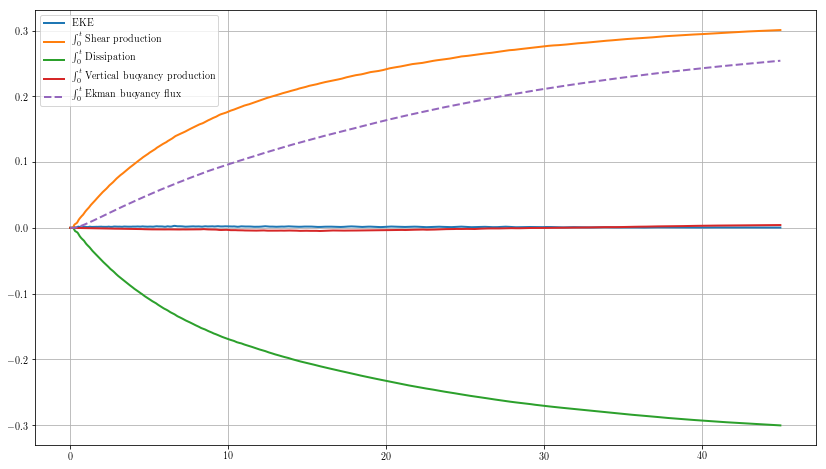

In [14]:
#EKE Fancy
Bekfull = -Bek[:,np.newaxis]*((zm[np.newaxis,:]-zm[0])/(H[:,np.newaxis]) -1 )/(1+N**2*np.tan(tht[0,0,0])**2/1e-8)
Bekfull[Bekfull> 0 ] = 0
Bekfull[np.isnan(Bekfull)] = 0

    
bdrag = (vm[:,0])*tauy/(1030)
damp = -0.005*((-20 - (z-z[-1]))/20)**2
damp[(z[:]-z[-1])<-20] = 0

damp = np.mean(damp*up*up + damp*vp*vp + damp*w[:,:,:]**2, axis=1)

EKETEST = EKE 
H[0:toff]=0
startind=0
zl = np.where((z>0) & (z<=z[-1]))[0]
bdrag = -1e-4*(EKE[:,0,1] - EKE[:,0,0])/(z[1]-z[0])
plt.figure(figsize=(14,8))
EKI = integrate.trapz(EKETEST[startind:,0,zl], x=z[zl], axis=-1)  - integrate.trapz(EKETEST[startind:,0,zl], x=z[zl], axis=-1)[0]
DRAGI = integrate.cumtrapz(bdrag[startind:], x=time[startind:], initial=0)
# DRAGSI = integrate.cumtrapz(bdrags[startind:], x=time[startind:], initial=0)
DAMPI = integrate.cumtrapz(integrate.trapz(damp[startind:,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)

# wzdiss = 1e-4*np.mean((np.gradient(w, axis=-1)/np.gradient(z[np.newaxis,np.newaxis,:], axis=-1))**2, axis=1)
DISSI = integrate.cumtrapz(integrate.trapz(diss[startind:,0,zl]+WDISS[startind:,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)
SPI = -integrate.cumtrapz(integrate.trapz(sp[startind:,0,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)
EKEEPEI = integrate.cumtrapz(integrate.trapz(vbfr[startind:,0,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)
BSCALE = integrate.cumtrapz(integrate.trapz(Bekfull[startind:,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)

SUM = DRAGI + DISSI + SPI + EKEEPEI+DAMPI

plt.plot(time[startind:]/86400, EKI, label='EKE', linewidth=2)
plt.plot(time[startind:]/86400, SPI, label='$\int_0^t$ Shear production', linewidth=2)
# plt.plot(time[startind:]/86400, integrate.cumtrapz(integrate.trapz(damp[startind:,zl], x=z[zl], axis=-1), x=time[startind:], initial=0), label='$Damp$')
plt.plot(time[startind:]/86400, DISSI, label='$\int_0^t$ Dissipation', linewidth=2)
# plt.plot(time[startind:]/86400, DAMPI, label='$\int_0^t DAMP$')

# # plt.plot(time/86400, np.sqrt(S)*N*H/(2*(1+S)*ubt)*dissi, label='Scaling')
# plt.plot(time[startind:]/86400, -integrate.cumtrapz((H[startind:]*Beka[startind:]/2, x=time[startind:], initial=0), label='Scaling')

# plt.plot(time[startind:]/86400, DRAGI, label='Drag')
# plt.plot(time[startind:]/86400, DRAGSI, label='Drag Scaling')

# plt.plot(time[startind:]/86400, integrate.cumtrapz(bdrag[startind:], x=time[startind:], initial=0), label='Drag')
plt.plot(time[startind:]/86400, EKEEPEI, label='$\int_0^t$ Vertical buoyancy production', linewidth=2)

plt.plot(time[startind:]/86400, -BSCALE, label='$\int_0^t$ Ekman buoyancy flux', linewidth=2, linestyle='dashed')

# plt.plot(time[startind:]/86400, SUM, linestyle='dashed', label='SUM RHS')
plt.legend()
plt.grid()
# plt.ylim((-2e-2, 2e-2))

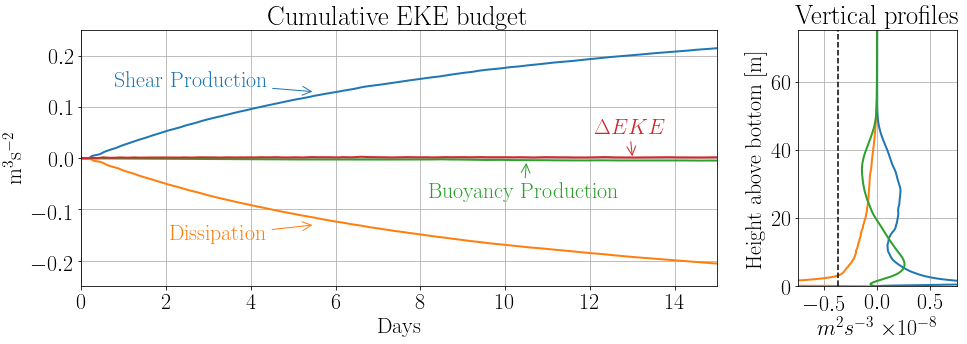

In [64]:
#EKE Fancy 2 panel


plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
# Bekfull = -Bek[:,np.newaxis]*((zm[np.newaxis,:]-zm[0])/(H[:,np.newaxis]) -1 )/(1+N**2*np.tan(tht[0,0,0])**2/1e-8)
# Bekfull[Bekfull> 0 ] = 0
# Bekfull[np.isnan(Bekfull)] = 0

    
# bdrag = (vm[:,0])*tauy/(1030)
# damp = -0.005*((-20 - (z-z[-1]))/20)**2
# damp[(z[:]-z[-1])<-20] = 0

# damp = np.mean(damp*up*up + damp*vp*vp + damp*w[:,:,:]**2, axis=1)

EKETEST = EKE 
startind=48*0
zl = np.where((z>0) & (z<=z[-1]))[0]
# bdrag = -1e-4*(EKE[:,0,1] - EKE[:,0,0])/(z[1]-z[0])
# plt.figure(figsize=(14,8))
fig, ax = plt.subplots(1, 2, sharey=False, figsize=(14, 5.25), gridspec_kw = {'width_ratios':[4, 1]})

# EKI = integrate.trapz(EKETEST[startind:,0,zl], x=z[zl], axis=-1)  - integrate.trapz(EKETEST[startind:,0,zl], x=z[zl], axis=-1)[0]
# DRAGI = integrate.cumtrapz(bdrag[startind:], x=time[startind:], initial=0)
# DRAGSI = integrate.cumtrapz(bdrags[startind:], x=time[startind:], initial=0)
# DAMPI = integrate.cumtrapz(integrate.trapz(damp[startind:,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)

# wzdiss = 1e-4*np.mean((np.gradient(w, axis=-1)/np.gradient(z[np.newaxis,np.newaxis,:], axis=-1))**2, axis=1)
# DISSI = integrate.cumtrapz(integrate.trapz(diss[startind:,0,zl]+WDISS[startind:,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)
# SPI = -integrate.cumtrapz(integrate.trapz(sp[startind:,0,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)
# EKEEPEI = integrate.cumtrapz(integrate.trapz(vbfr[startind:,0,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)
# BSCALE = integrate.cumtrapz(integrate.trapz(Bekfull[startind:,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)

SUM = DRAGI + DISSI + SPI + EKEEPEI+DAMPI

# ax[0].plot(time[startind:]/86400, EKI, label='EKE', linewidth=2)

ax[0].plot(time[startind:]/86400, SPI, label='$\int_0^t$ Shear production', linewidth=2)
# plt.plot(time[startind:]/86400, integrate.cumtrapz(integrate.trapz(damp[startind:,zl], x=z[zl], axis=-1), x=time[startind:], initial=0), label='$Damp$')
ax[0].plot(time[startind:]/86400, DISSI, label='$\int_0^t$ Dissipation', linewidth=2)
# plt.plot(time[startind:]/86400, DAMPI, label='$\int_0^t DAMP$')

# # plt.plot(time/86400, np.sqrt(S)*N*H/(2*(1+S)*ubt)*dissi, label='Scaling')
# ax[0].plot(time[startind:]/86400, -integrate.cumtrapz(H[startind:]*Beka[startind:]/2, x=time[startind:], initial=0), label='Scaling')
# plt.plot(time[startind:]/86400, DRAGI, label='Drag')
# plt.plot(time[startind:]/86400, DRAGSI, label='Drag Scaling')

# plt.plot(time[startind:]/86400, integrate.cumtrapz(bdrag[startind:], x=time[startind:], initial=0), label='Drag')
ax[0].plot(time[startind:]/86400, EKEEPEI, label='$\int_0^t$ Vertical buoyancy production', linewidth=2)
ax[0].plot(time[startind:]/86400, EKI, label='EKE', linewidth=2)
# ax[0].plot(time[startind:]/86400, integrate.cumtrapz(H[startind:]*Beka[startind:]/2, x=time[startind:], initial=0), 
#            label='Scaling')

# plt.plot(time[startind:]/86400, BSCALE, label='$\int_0^t$ Ekman buoyancy flux', linewidth=2)

# plt.plot(time[startind:]/86400, SUM, linestyle='dashed', label='SUM RHS')
# ax[0].legend()
ax[0].grid()
ax[0].set_title('Cumulative EKE budget')
ax[0].set_xlim((0, 15))
ax[0].set_xlabel('Days')
ax[0].set_ylabel('m$^3$s$^{-2}$')
# plt.ylim((-2e-2, 2e-2))
ax[0].set_ylim(-0.25, 0.25)
ti = np.where((time/86400>10) & (time/86400<15))[0]

# ENERGY PROFILES
ax[1].plot(-np.mean(np.mean(sp[ti,:,:], axis=1), 0)*1e8, zm-zm[0], label='Shear production', linewidth=2)
# ax[1].plot(np.mean(RGSP[ti,:], 0), zm-zm[0], label='SP', linewidth=2)

ax[1].plot(np.mean(np.mean(diss[ti,:,:], axis=1), 0)*1e8, zm-zm[0], label='Dissipation', linewidth=2)
# ax[1].plot(np.mean(np.mean(vbfr[ti,:,:,] - sp[ti,:,:], axis=1), 0), zm-zm[0], label='SP', linewidth=2)
# ax[1].plot(np.mean(np.mean(vbfr[ti,:,:,], axis=1)+RGSP[ti,:], 0), zm-zm[0], label='SP', linewidth=2)
ax[1].plot(np.mean(np.mean(vbfr[ti,:,:], axis=1), axis=0)*1e8, zm-zm[0], label='Vertical buoyancy\n production', linewidth=2)

ax[1].axvline(np.mean(Beka[ti])*1e8, color='k', linestyle='dashed', label='Bottom Ekman\n buoyancy flux')
# ax[1].axvline(np.mean(Bek[ti]/Ri[ti]), color='k', linestyle='dashed')
ax[1].grid()
ax[1].set_xlabel('$m^2s^{-3}$ $\\times 10^{-8}$')
# ax[1].legend(loc=9, bbox_to_anchor=(-4, 1), ncol=2, fontsize='small')
# ax[1].legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
#           ncol=3, fancybox=True, shadow=True)
ax[1].set_xlim(-0.75, 0.75)
ax[1].set_ylim(0, 75)
ax[1].set_ylabel('Height above bottom [m]')
ax[1].set_title('Vertical profiles')

# Add annotations
ax[0].annotate("$ \Delta EKE$",
            xy=(13, 0.0), xycoords='data',
            xytext=(12.1, 0.05), textcoords='data',
            color='#d62728',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3",
                            color='#d62728'),
            )
ax[0].annotate("Buoyancy Production",
            xy=(10.5, -0.005), xycoords='data',
            xytext=(8.2, -0.075), textcoords='data',
            color='#2ca02c',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3",
                            color='#2ca02c'),
            )
ax[0].annotate("Shear Production",
            xy=(5.5, 0.13), xycoords='data',
            xytext=(0.8, 0.14), textcoords='data',
            color='#1f77b4',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3",
                            color='#1f77b4'),
            )
ax[0].annotate("Dissipation",
            xy=(5.5, -0.13), xycoords='data',
            xytext=(2.1, -0.16), textcoords='data',
            color='#ff7f0e',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3",
                            color='#ff7f0e'),
            )
plt.tight_layout()


# plt.savefig('EnergyCumulative_1e-5_0p02.pdf', bbox_inches='tight', pad=0.1)

In [13]:
fig, ax = plt.subplots(1, 2, sharey=False, figsize=(14, 5.25), gridspec_kw = {'width_ratios':[4, 1]})

# EKI = integrate.trapz(EKETEST[startind:,0,zl], x=z[zl], axis=-1)  - integrate.trapz(EKETEST[startind:,0,zl], x=z[zl], axis=-1)[0]
# DRAGI = integrate.cumtrapz(bdrag[startind:], x=time[startind:], initial=0)
# DRAGSI = integrate.cumtrapz(bdrags[startind:], x=time[startind:], initial=0)
# DAMPI = integrate.cumtrapz(integrate.trapz(damp[startind:,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)

# wzdiss = 1e-4*np.mean((np.gradient(w, axis=-1)/np.gradient(z[np.newaxis,np.newaxis,:], axis=-1))**2, axis=1)
# DISSI = integrate.cumtrapz(integrate.trapz(diss[startind:,0,zl]+WDISS[startind:,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)
# SPI = -integrate.cumtrapz(integrate.trapz(sp[startind:,0,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)
# EKEEPEI = integrate.cumtrapz(integrate.trapz(vbfr[startind:,0,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)
# BSCALE = integrate.cumtrapz(integrate.trapz(Bekfull[startind:,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)

SUM = DRAGI + DISSI + SPI + EKEEPEI+DAMPI

# ax[0].plot(time[startind:]/86400, EKI, label='EKE', linewidth=2)


ax[0].plot(time[startind:]/86400, SPI, label='$\int_0^t$ Shear production', linewidth=2)
# plt.plot(time[startind:]/86400, integrate.cumtrapz(integrate.trapz(damp[startind:,zl], x=z[zl], axis=-1), x=time[startind:], initial=0), label='$Damp$')
ax[0].plot(time[startind:]/86400, DISSI, label='$\int_0^t$ Dissipation', linewidth=2)
# plt.plot(time[startind:]/86400, DAMPI, label='$\int_0^t DAMP$')

# # plt.plot(time/86400, np.sqrt(S)*N*H/(2*(1+S)*ubt)*dissi, label='Scaling')
# ax[0].plot(time[startind:]/86400, -integrate.cumtrapz(H[startind:]*Beka[startind:]/2, x=time[startind:], initial=0), label='Scaling')
# plt.plot(time[startind:]/86400, DRAGI, label='Drag')
# plt.plot(time[startind:]/86400, DRAGSI, label='Drag Scaling')

# plt.plot(time[startind:]/86400, integrate.cumtrapz(bdrag[startind:], x=time[startind:], initial=0), label='Drag')
ax[0].plot(time[startind:]/86400, EKEEPEI, label='$\int_0^t$ Vertical buoyancy production', linewidth=2)
ax[0].plot(time[startind:]/86400, EKI, label='EKE', linewidth=2)
Htemp =H
Htemp[~np.isfinite(Htemp)] =0
ax[0].plot(time[startind:]/86400, -integrate.cumtrapz(Htemp[startind:]Bek[startind:]/2, x=time[startind:], initial=0), 
           label='Scaling')


SyntaxError: invalid syntax (<ipython-input-13-cf5005a6a964>, line 34)

## MPE

In [ ]:
startind=48*0
zl = np.where((z>0) & (z<=300))[0]
damp = -0.005*((-20 - (z-z[-1]))/20)**2
damp[(z[:]-z[-1])<-20] = 0

damp = damp*bm**2/N**2
plt.figure(figsize=(15,10))

MPEI = integrate.trapz(MPE[startind:,zl], x=z[zl], axis=-1)  - integrate.trapz(MPE[startind:,zl], x=z[zl], axis=-1)[0]

MMIXI = integrate.cumtrapz(integrate.trapz(MMIX[startind:,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)
BPRODI = integrate.cumtrapz(integrate.trapz(BPROD[startind:,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)
MKEMPEI = integrate.cumtrapz(integrate.trapz(MKEMPE[startind:,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)
DAMPI = integrate.cumtrapz(integrate.trapz(damp[startind:,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)

SUM = MMIXI + BPRODI - MKEMPEI
plt.plot(time[startind:]/86400, MPEI, label='MPE')
plt.plot(time[startind:]/86400, BPRODI, label='$\int_0^t BPROD$')
# plt.plot(time[startind:]/86400, integrate.cumtrapz(integrate.trapz(damp[startind:,zl], x=z[zl], axis=-1), x=time[startind:], initial=0), label='$Damp$')
plt.plot(time[startind:]/86400, MMIXI, label='$\int_0^t MMIX$')

# # plt.plot(time/86400, np.sqrt(S)*N*H/(2*(1+S)*ubt)*dissi, label='Scaling')
# plt.plot(time[startind:]/86400, integrate.cumtrapz(H[startind:]*Beka[startind:]/2, x=time[startind:], initial=0), label='Scaling')
plt.plot(time[startind:]/86400, DAMPI, label='Damping')

# plt.plot(time[startind:]/86400, integrate.cumtrapz(bdrag[startind:], x=time[startind:], initial=0), label='Drag')
plt.plot(time[startind:]/86400, -MKEMPEI, label='MKE-MPE')
plt.plot(time[startind:]/86400, SUM, linestyle='dashed', label='SUM RHS')
plt.legend()
plt.grid()

## EPE

In [ ]:
startind=48*0
zl = np.where((z>0) & (z<=z[-1]))[0]
plt.figure(figsize=(15,10))
# vbfrtest = EKEt - (diss[:,0,zl]-sp[:,0,zl]+WDISS)

damp = -0.005*((-20 - (z-z[-1]))/20)**2
damp[(z[:]-z[-1])<-20] = 0

damp = np.mean(damp*bp**2, axis=1)/N**2
bdrag = -1e-4*(EPE[:,1] - EPE[:,0])/(z[1]-z[0])

EPEI = integrate.trapz(EPE[startind:,zl], x=z[zl], axis=-1)  - integrate.trapz(EPE[startind:,zl], x=z[zl], axis=-1)[0]

# MIXI = integrate.cumtrapz(integrate.trapz(MIX[startind:,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)
MIXI = integrate.cumtrapz(integrate.trapz(dissb[startind:,0,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)

BPRODI = integrate.cumtrapz(integrate.trapz(BPROD[startind:,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)
EKEEPEI = integrate.cumtrapz(integrate.trapz(vbfr[startind:,0,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)
DAMPI = integrate.cumtrapz(integrate.trapz(damp[startind:,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)
DRAGI = integrate.cumtrapz(bdrag[startind:], x=time[startind:], initial=0)

SUM = MIXI - BPRODI - EKEEPEI + DAMPI
plt.plot(time[startind:]/86400, EPEI, label='EPE')
plt.plot(time[startind:]/86400,- BPRODI, label='$-\int_0^t BPROD$')
# plt.plot(time[startind:]/86400, integrate.cumtrapz(integrate.trapz(damp[startind:,zl], x=z[zl], axis=-1), x=time[startind:], initial=0), label='$Damp$')
plt.plot(time[startind:]/86400, MIXI, label='$\int_0^t MIX$')

# # plt.plot(time/86400, np.sqrt(S)*N*H/(2*(1+S)*ubt)*dissi, label='Scaling')
# plt.plot(time[startind:]/86400, integrate.cumtrapz(H[startind:]*Beka[startind:]/2, x=time[startind:], initial=0), label='Scaling')
plt.plot(time[startind:]/86400, DAMPI, label='Damping')
plt.plot(time[startind:]/86400, DRAGI, label='DRAG')

# plt.plot(time[startind:]/86400, integrate.cumtrapz(bdrag[startind:], x=time[startind:], initial=0), label='Drag')
plt.plot(time[startind:]/86400, -EKEEPEI, label='EKE-EPE')
plt.plot(time[startind:]/86400, SUM, linestyle='dashed', label='SUM RHS')
plt.legend()
plt.grid()

In [ ]:
zl

## Mixing Efficiencies

In [ ]:
# Ratio of MPE to cumulative dissipation (include both mean and EKE dissipation)
mdiss = -1e-4*uz**2 - 1e-4*vz**2
WDISS = -1e-4*np.mean(wz**2 + wx**2, axis=1)

startind=0
zl = range(0, 256)
DISSIT = integrate.cumtrapz(integrate.trapz(mdiss[startind:,zl] + diss[startind:,0,zl]+WDISS[startind:,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)
MPEI = integrate.trapz(MPE[startind:,zl], x=z[zl], axis=-1)  - integrate.trapz(MPE[startind:,zl], x=z[zl], axis=-1)[0]
EKEEPEI = integrate.cumtrapz(integrate.trapz(vbfr[startind:,0,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)
MIXI = integrate.cumtrapz(integrate.trapz(dissb[startind:,0,zl], x=z[zl], axis=-1), x=time[startind:], initial=0)

plt.figure(figsize=(10,5))
plt.plot(time[startind:]/86400, -MPEI/DISSIT,linewidth=2, label='$MPE(t)/\int_0^t \epsilon$')
plt.plot(time[startind:]/86400, MIXI/DISSIT,linewidth=2, label='$\int_0^t \epsilon_b/\int_0^t \epsilon$')
plt.plot(time[startind:]/86400, EKEEPEI/DISSIT,linewidth=2, label='$\int_0^t VBF/\int_0^t \epsilon$') # VBF/EPSILON (cumulative in time)
plt.ylim(-0.1,1)
plt.grid()
plt.legend()

## EXTRAS


In [ ]:
etest = EKI - DRAGI-DISSI-DAMPI-SPI

plt.plot(etest)
plt.plot(EKEEPEI)

In [ ]:
plt.plot(integrate.trapz(mdiss[:,:], x=z, axis=-1))

In [ ]:
z[zl]

In [ ]:
time[100]/86400

In [ ]:
MIXI

In [ ]:
plt.plot(MPEI)